# RNNs for Time Series Prediction

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import os

# default - all messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 

# INFO suppressed
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# INFO and WARNING suppressed
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# INFO, WARNING, ERROR suppressed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL']

'3'

## Time series

In [44]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


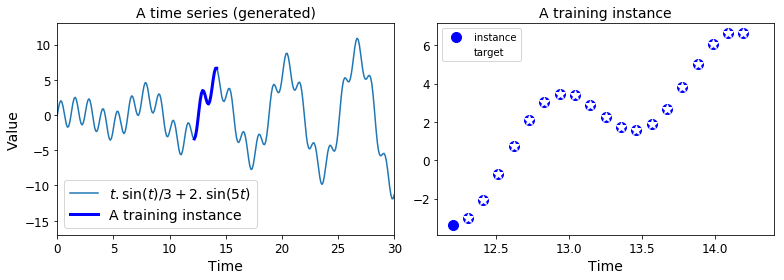

In [45]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [46]:
X_batch, y_batch = next_batch(1, n_steps)

# Preview input/output sequences

In [47]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Training the model

In [58]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [59]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [60]:
n_outputs = 1
learning_rate = 0.001

In [61]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [62]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [63]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907031
100 	MSE: 0.50563276
200 	MSE: 0.1972298
300 	MSE: 0.1026313
400 	MSE: 0.067478806
500 	MSE: 0.06297704
600 	MSE: 0.05659878
700 	MSE: 0.050051264
800 	MSE: 0.0505437
900 	MSE: 0.04874706


In [64]:
y_pred

array([[[-3.4561932],
        [-2.5313642],
        [-1.2407991],
        [ 0.6343986],
        [ 2.1777737],
        [ 3.0509517],
        [ 3.4353473],
        [ 3.3772285],
        [ 2.8565996],
        [ 2.2164276],
        [ 1.6965914],
        [ 1.4880891],
        [ 1.8545593],
        [ 2.720763 ],
        [ 3.8677568],
        [ 5.102808 ],
        [ 6.092204 ],
        [ 6.629778 ],
        [ 6.5972834],
        [ 6.00503  ]]], dtype=float32)

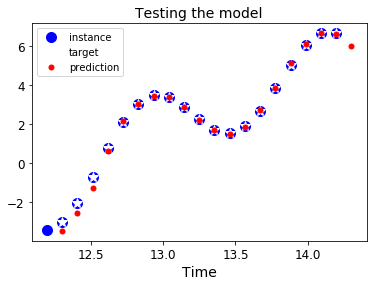

In [65]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [66]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


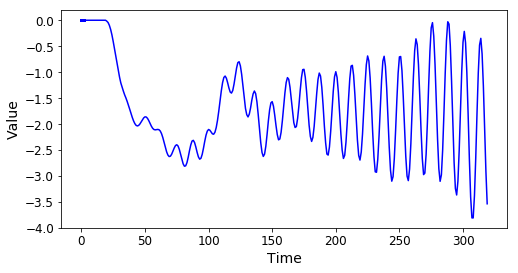

In [67]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


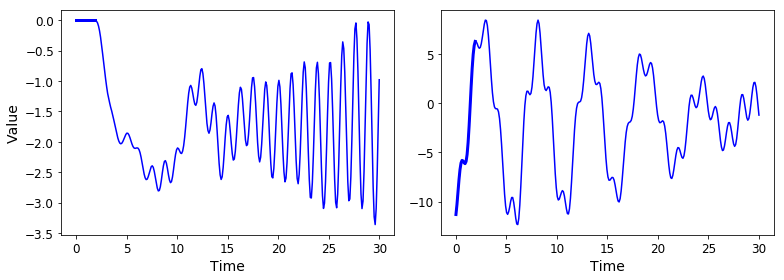

In [68]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()